In [52]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns

import pickle
import time

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

from rerf.rerfClassifier import rerfClassifier

import warnings
warnings.simplefilter('ignore')

In [132]:
def samp(n1,n2):
    n1,n2 = int(n1),int(n2)
    X1 = np.empty((n1,100))
    Y1 = np.full(n1,0)
    for i in range(n1):        
        cir = np.zeros(100)
        
        s1 = np.random.choice(range(0,100)) # Random Location
        l1 = [j%100 for j in range(s1,s1+5)] # Length 5 vector from s1
        
        exclude_idx = set([j%100 for j in range(s1-5,s1+6)])
        s2 = np.random.choice(list(set(range(0,100)).difference(exclude_idx)))
        l2 = [j%100 for j in set(range(s2,s2+5)).difference(set(l1))]
        
        cir[l1] = 1
        cir[l2] = 1
        
        X1[i] = cir
        
    X2 = np.empty((n2,100))
    Y2 = np.full(n2,1)
    for i in range(n2):        
        cir = np.zeros(100)
        
        s1 = np.random.choice(range(0,100)) # Random location   
        l1 = [j%100 for j in range(s1,s1+4)] # Length 4 vector from s1
        
        exclude_idx = set([j%100 for j in range(s1-6,s1+5)])
        s2 = np.random.choice(list(set(range(0,100)).difference(exclude_idx)))
        l2 = [j%100 for j in set(range(s2,s2+6)).difference(set(l1))]
        
        cir[l1] = 1
        cir[l2] = 1
        
        X2[i] = cir
        
    return((np.vstack([X1,X2]),np.hstack([Y1,Y2])))

In [133]:
np.random.seed(1234)
ns = np.array([50,100,200,400,1000,2000])
n1 = ns
n2 = ns
TRAIN_FRAC = 0.5
TEST_FRAC = 1-TRAIN_FRAC
n1_train, n2_train = n1*TRAIN_FRAC, n2*TRAIN_FRAC
n1_test, n2_test = n1*TEST_FRAC, n2*TEST_FRAC

In [134]:
X_train = []
Y_train = []
for i1,i2 in zip(n1_train,n2_train):
    x_train,y_train = samp(i1,i2)
    shuffled_idx = list(range(len(y_train))); np.random.shuffle(shuffled_idx)
    X_train.append(x_train[shuffled_idx])
    Y_train.append(y_train[shuffled_idx])

In [135]:
X_test = []
Y_test = []
for i1,i2 in zip(n1_test,n2_test):
    x_test,y_test = samp(i1,i2)
    shuffled_idx = list(range(len(y_test))); np.random.shuffle(shuffled_idx)
    X_test.append(x_test[shuffled_idx])
    Y_test.append(y_test[shuffled_idx])

In [152]:
def max_consec(a):
    l = 0
    max_l = 0
    for i in a:
        if i == 1:
            l += 1
        else:
            max_l = max(max_l,l)
            l = 0
            
    l = 0 
    max_l2 = 0
    for i in list(a[50:]) + list(a[:50]):
        if i == 1:
            l += 1
        else:
            max_l2 = max(max_l2,l)
            l = 0
    return(max(max_l,max_l2))

(array([   0., 1875., 1875.,    0.,    0.,    0.,    0.]),
 array([ 3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5]),
 <a list of 7 Patch objects>)

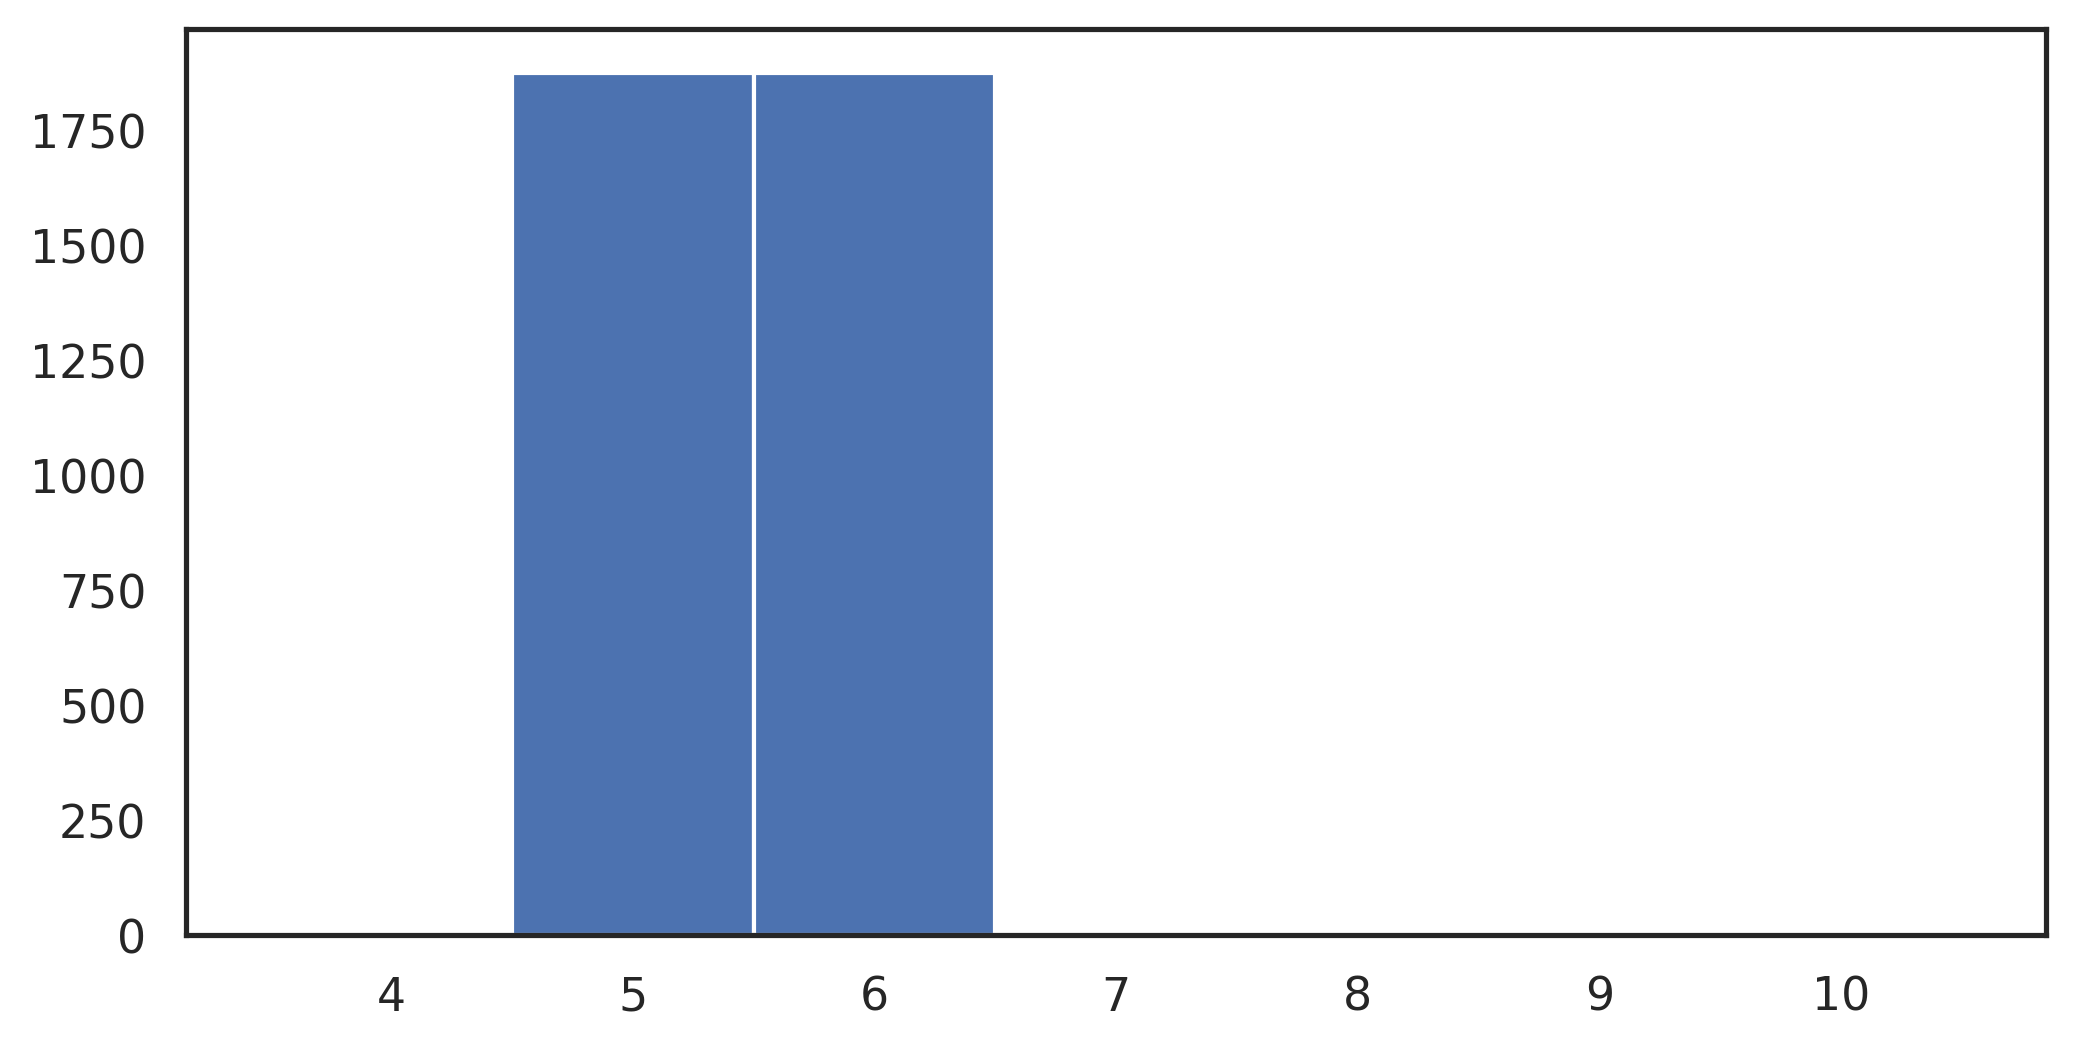

In [154]:
plt.hist([max_consec(a) for x in X_test for a in x], bins=[i for i in np.arange(3.5,11.5)])

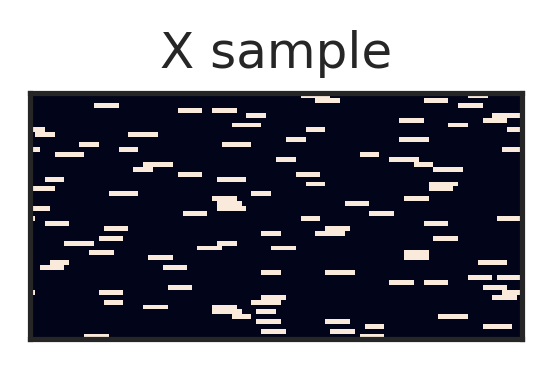

In [171]:
fig = plt.figure(figsize=(2,2),facecolor='white')
plt.imshow(X_train[0])
plt.title("X sample")
frame1 = plt.gca()
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.tight_layout()
plt.show()

In [181]:
## Setup for run
names = {"Log. Reg": "blue", "Lin. SVM":"firebrick", "SVM":"purple", 
          "kNN": "black", "RF":"#f86000", "MLP":"green", "S-RerF":"red"}

ncores=1
num_runs=5
n_est=100

classifiers = [
    LogisticRegression(random_state=0, n_jobs=ncores, solver='liblinear'),
    LinearSVC(),
    SVC(C=1.0, kernel='rbf', gamma='auto',random_state=0),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
    MLPClassifier(hidden_layer_sizes=(100, ), random_state=0),
    rerfClassifier(projection_matrix="S-RerF",
                   max_features=40,
                   n_jobs=ncores,
                    n_estimators=n_est,
                    oob_score=False,
                    random_state=0,
                    image_height=1,
                    image_width=100,
                    patch_height_max=1,
                    patch_height_min=1,
                    patch_width_max=15,
                    patch_width_min=1
                   )
    ]

In [182]:
# iterate
## Prep output file:
f = open('s-rerf_circle_5runs.csv', 'w+')
f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
f.flush()

runList = [(n, clf, i, run) for n in ns\
                       for clf in zip(classifiers, [key for key in names])\
                       for i in range(len(X_train))\
                       for run in range(num_runs)]

for n, clf, i, iteration in runList:
        X = X_train[i]
        y = Y_train[i]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test[i])
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test[i]).astype(int))


        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(f"{clf[1]}, {ns[i]}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n")
        f.flush()

f.close()

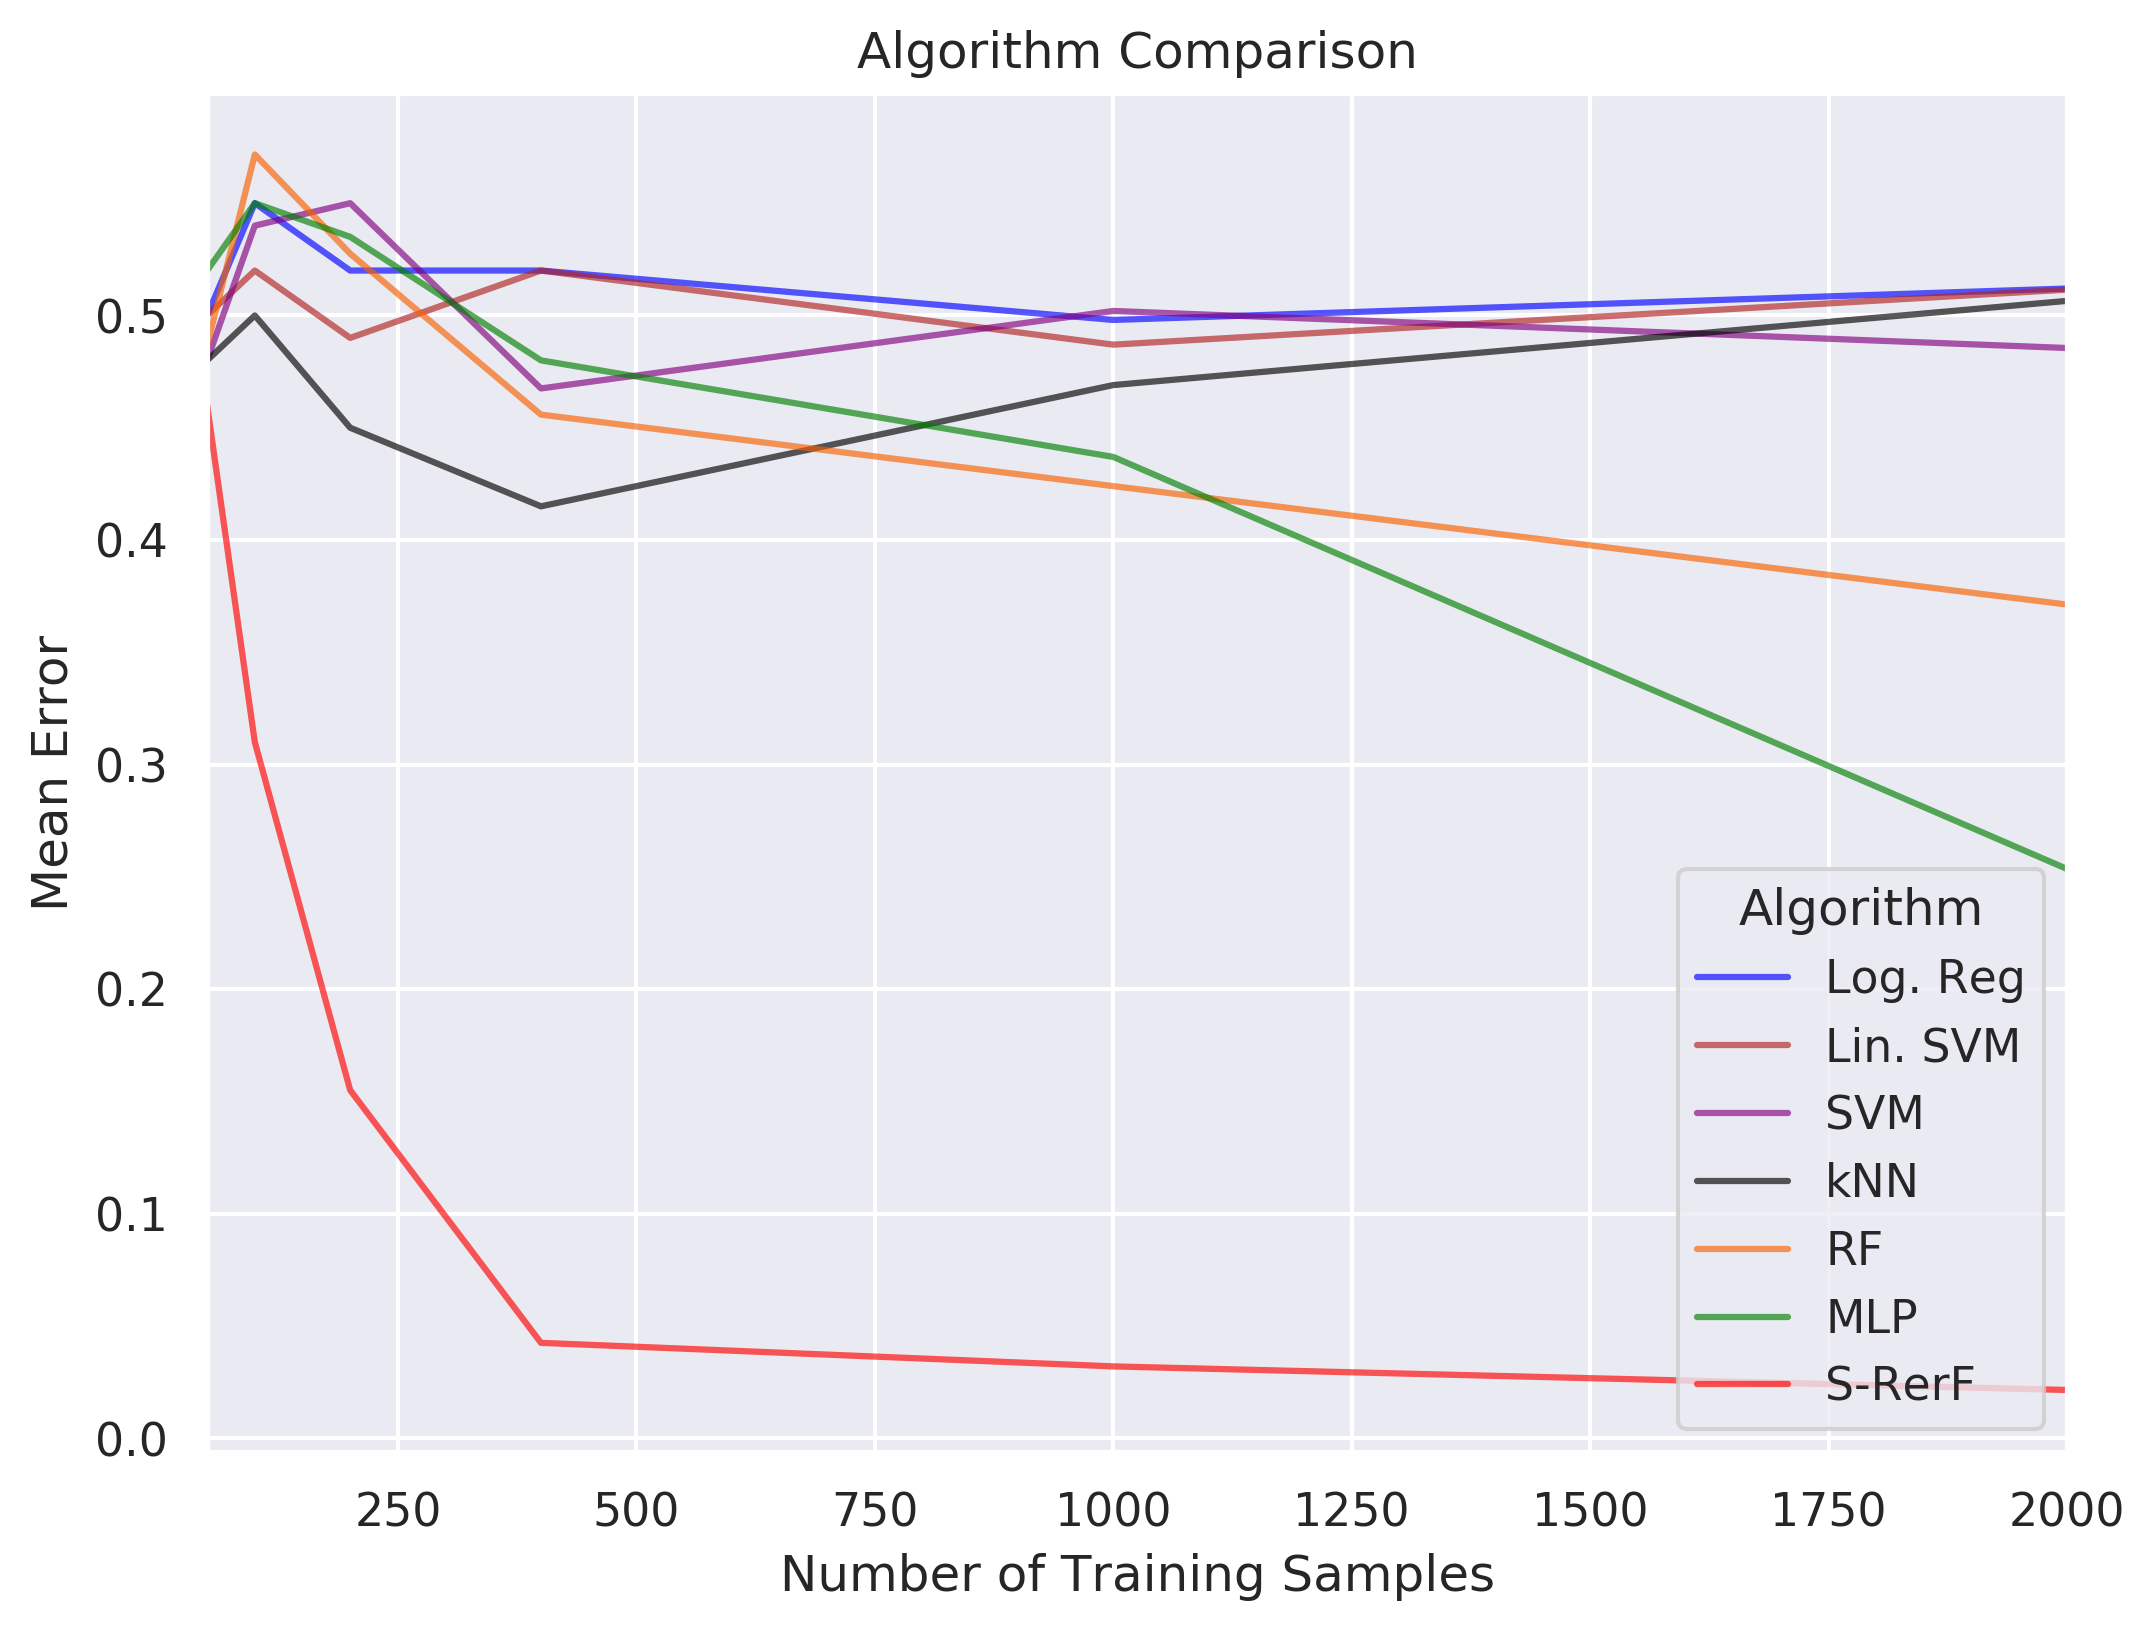

In [180]:
dat = pd.read_csv("s-rerf_circle_runs.csv")

#d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        #se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        #d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})        
#matplotlib.rc('figure', figsize=[12,8], dpi = 300)
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
#for key, grp in d1.groupby(['classifier']):
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_xscale('log', basex=2)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Error')
plt.xlabel('Number of Training Samples')
plt.show()

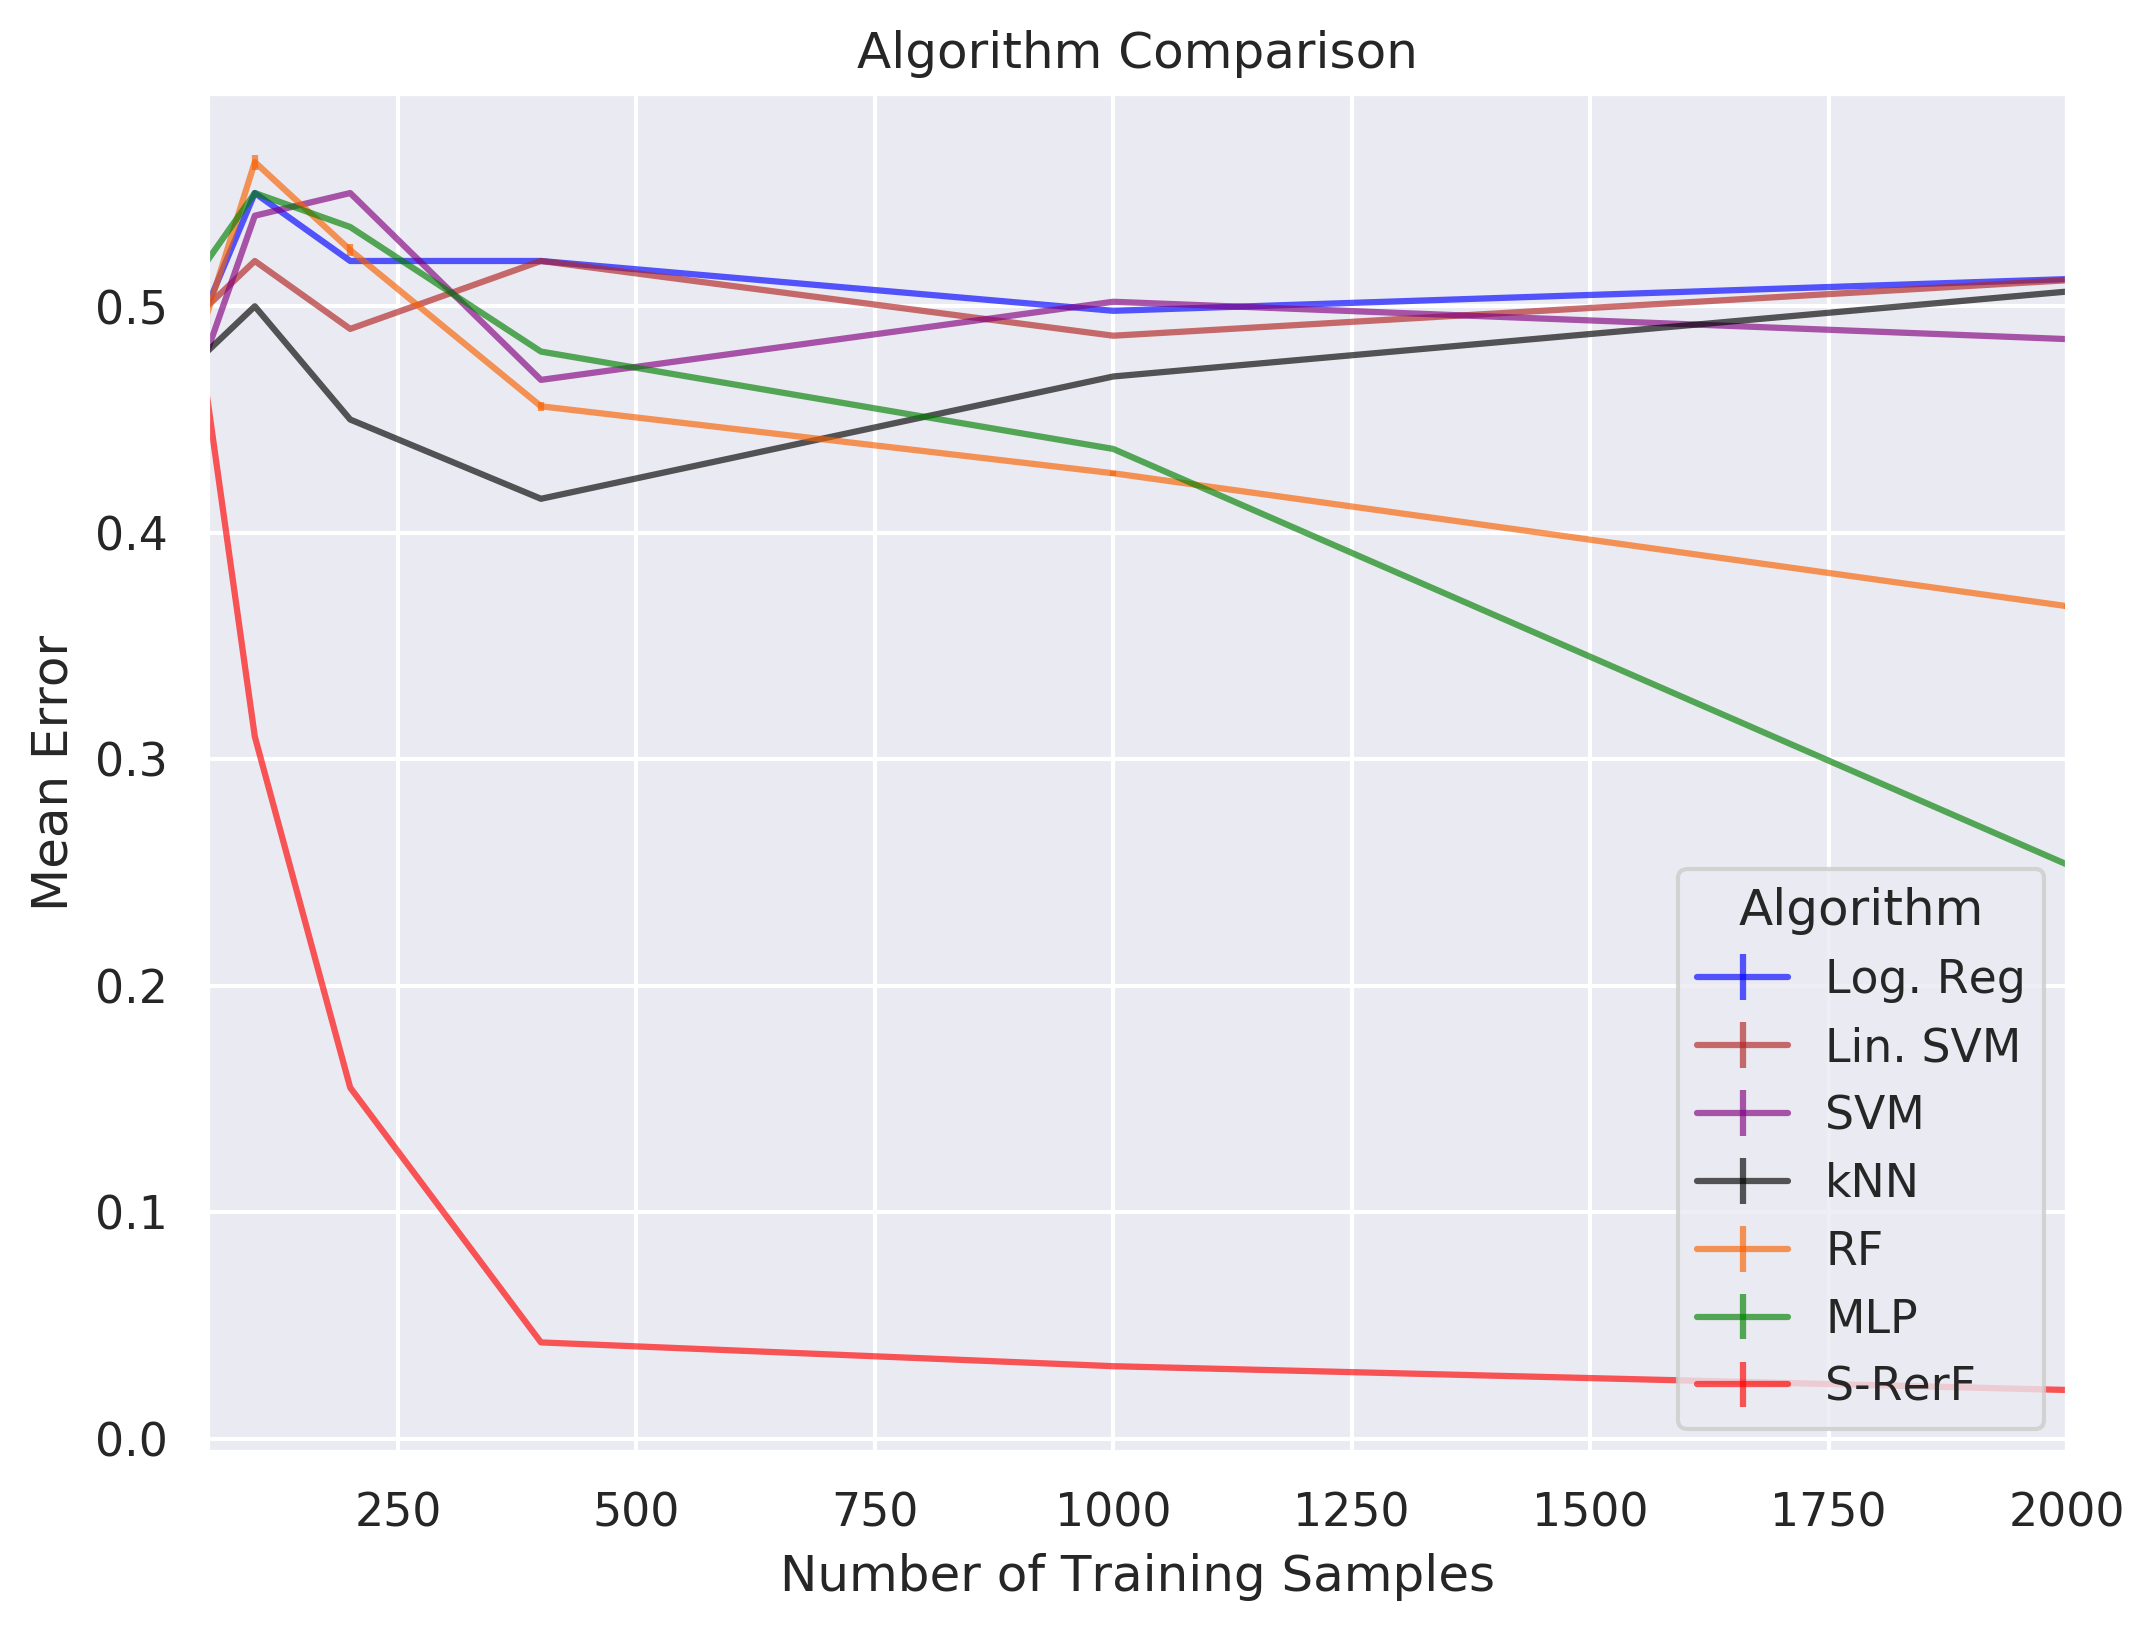

In [184]:
dat = pd.read_csv("s-rerf_circle_5runs.csv")

d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'se', 'color'])
#d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [se] + [names[cl]]
        #d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})        
#matplotlib.rc('figure', figsize=[12,8], dpi = 300)
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key] 
#for key, grp in d1.groupby(['classifier']):
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], yerr = 'se', alpha =0.65)
    #ax.set_xscale('log', basex=2)
    #ax.set_yscale('log')

plt.legend(loc='best',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Error')
plt.xlabel('Number of Training Samples')
plt.show()